In [162]:
import numpy
from pandas import read_csv
from pandas import Series
from datetime import datetime
from pandas import DataFrame
from pandas import concat
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [163]:
data_dir = "../Data"

In [164]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# load dataset
series = read_csv(
    os.path.join("SPY.csv"),
    header=0,
    parse_dates=[0],
    index_col=0,
    squeeze=True)
series = series[["Adj Close"]].dropna()

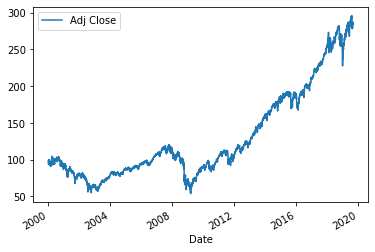

In [165]:
series.plot()

Series is clearly not stationary! Let's try first difference.

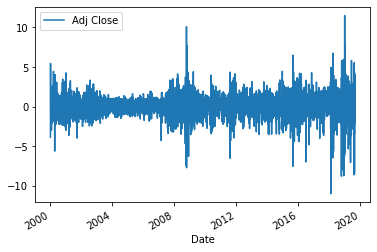

In [166]:
series.diff().plot()

This looks stationary (enough). Possibly heteroskedastic but we'll ignore this for now.

In [167]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [168]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [169]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform to supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

LSTM requires data to be scaled between -1 and 1 to be effective.

In [170]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [171]:
train, test = supervised_values[0:-1200], supervised_values[-1200:]
scaler, train_scaled, test_scaled = scale(train, test)

In [172]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    optimizer = optimizers.Adam(clipvalue=0.5)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    for i in range(nb_epoch):
        print("Epoch #{}".format(i+1))
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [173]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 10, 10)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch #1
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0168
Epoch #2
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0165
Epoch #3
3739/3739 [==============================] - 4s 1ms/step - loss: 0.0165
Epoch #4
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0164
Epoch #5
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0164
Epoch #6
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0164
Epoch #7
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0164
Epoch #8
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0164
Epoch #9
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0164
Epoch #10
3739/3739 [==============================] - 5s 1ms/step - loss: 0.0164


array([[-0.06986075],
       [-0.05641732],
       [-0.09754017],
       ...,
       [-0.13174252],
       [-0.13190198],
       [-0.13052249]], dtype=float32)

In [174]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [175]:
predictions = list()
actuals = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    actuals.append(expected)

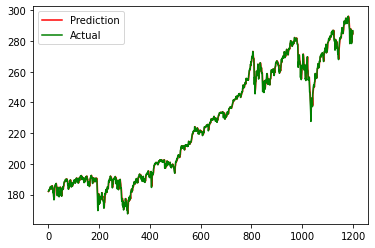

In [176]:
plt.plot(list(range(len(test_scaled))), predictions, color="r", label="Prediction")
plt.plot(list(range(len(test_scaled))), actuals, color="g", label="Actual")
plt.legend()

In [177]:
rmse = numpy.sqrt(mean_squared_error(actuals, predictions))
print("Mean Square Error: {}".format(rmse))

Mean Square Error: 1.9319707749978612


In [178]:
actuals = Series(actuals).astype(float)
predictions = Series(predictions).astype(float)

In [199]:
actuals_ret = numpy.log(actuals).diff().dropna().reset_index(drop=True)
predictions_ret = list()
for i in range(len(actuals)-1):
    predictions_ret.append(numpy.log(predictions[i+1]) - numpy.log(actuals[i]))
predictions_ret = Series(predictions_ret)

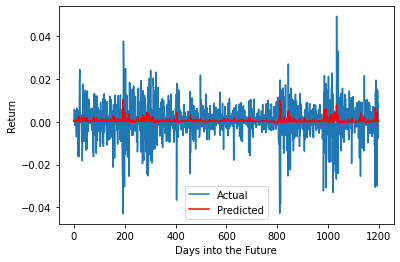

In [200]:
plt.plot(actuals_ret, label="Actual")
plt.plot(predictions_ret, color='red', label="Predicted")
plt.xlabel("Days into the Future")
plt.ylabel("Return")
plt.legend()
plt.show()

In [201]:
accuracy = numpy.sum(numpy.sign(predictions_ret) == numpy.sign(actuals_ret))/len(predictions)
print("Accuracy is {}%".format(accuracy*100))

Accuracy is 53.25%


Test RMSE: 1.937


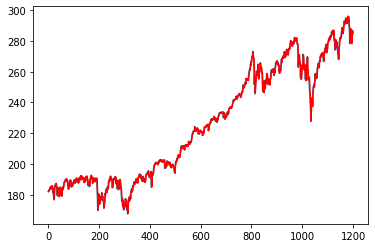

In [202]:
X = series.values
size = -1200
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % numpy.sqrt(error))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [203]:
test = Series(test[:, 0])
predictions = Series(predictions).astype(float)

In [213]:
test_ret = numpy.log(test).diff().dropna().reset_index(drop=True)
predictions_ret = list()
for i in range(len(actuals)-1):
    predictions_ret.append(numpy.log(predictions[i+1]) - numpy.log(test[i]))
predictions_ret = Series(predictions_ret)

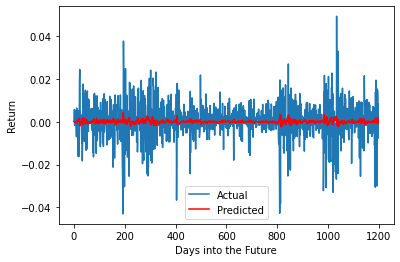

In [215]:
plt.plot(actuals_ret, label="Actual")
plt.plot(predictions_ret, color='red', label="Predicted")
plt.xlabel("Days into the Future")
plt.ylabel("Return")
plt.legend()
plt.show()

In [216]:
accuracy = numpy.sum(numpy.sign(predictions_ret) == numpy.sign(test_ret))/len(predictions)
print("Accuracy is {}%".format(accuracy*100))

Accuracy is 50.0%


In [217]:
train

array([[ 98.95903015],
       [ 95.0891037 ],
       [ 95.25919342],
       ...,
       [181.9553833 ],
       [182.13378906],
       [181.93757629]])

In [221]:
# Naive model
# Predict yesterday's value and return
predictions = list()
for t in range(len(test)):
    if t == 0:
        yhat = float(train[-1])
    else:
        yhat = test[t-1]
    predictions.append(yhat)

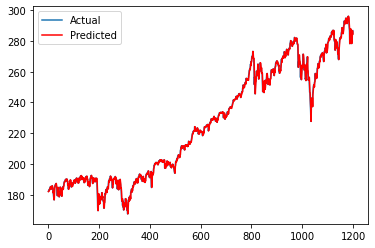

In [226]:
plt.plot(test, label="Actual")
plt.plot(predictions, color='red', label="Predicted")
plt.legend()
plt.show()

In [223]:
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % numpy.sqrt(error))

Test RMSE: 1.934
